# Imports

## Common

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset, Subset, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
!pip install prv-accountant

from IPython.display import clear_output

## HF

In [ ]:
!pip install datasets
!pip install transformers
!pip install timm

import transformers
import datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.6 MB/s eta 0:00:00


## drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utils

## Deep Hypersphere

In [ ]:
# model

import torch.nn as nn
import torch.nn.functional as F


class CentroidClassifier(nn.Module):
    def __init__(self, embedding_size, class_number):
        super().__init__()
        self.embedding_projection = nn.Linear(embedding_size, embedding_size)
        self.classifier = nn.Linear(embedding_size, class_number)

    def forward(self, x):
        x = F.normalize(x)
        x = self.embedding_projection(x)
        x = F.relu(x)
        x = F.normalize(x)
        cls = self.classifier(x)
        return {'cls' : cls, 'embeddings': x}


class NormalClassifier(nn.Module):
    def __init__(self, embedding_size, class_number):
        super().__init__()
        self.classifier = nn.Linear(embedding_size, class_number)

    def forward(self, x):
        x = F.dropout(x, p=0.5, training = self.training)
        x = self.classifier(x)
        cls = x
        return {'cls' : cls, 'embeddings': x}



## Deep Models

In [ ]:
class ModelExperiment():
  def __init__(self, model_name = 'dino_vitb16'):
    self.model_name = model_name
    self.models = dict()

    self.download()

  def download(self):
    models = dict()

    match self.model_name:

      # Vision Models
      case 'resnet50':
        models['model'] = torchvision.models.resnet50(weights = 'DEFAULT')

      case 'resnet152':
        models['model'] = torchvision.models.resnet152(weights = 'DEFAULT')

      case 'dino_vitb16':
        models['model'] = transformers.ViTModel.from_pretrained('facebook/dino-vitb16')

      case 'msn_vitb16':
        models['model'] = transformers.ViTMSNModel.from_pretrained('facebook/vit-msn-base')

      case 'vgg19':
        models['model'] = torchvision.models.vgg19(weights = 'DEFAULT')

      # NLP Models
      case 'data2vec':
        hf_path = 'facebook/data2vec-text-base'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'unsup_simcse_roberta_base':
        hf_path = 'princeton-nlp/unsup-simcse-roberta-base'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'unsup_simcse_roberta_large':
        hf_path = 'princeton-nlp/unsup-simcse-roberta-large'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'sup_simcse_roberta_base':
        hf_path = 'princeton-nlp/sup-simcse-roberta-base'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'sup_simcse_roberta_large':
        hf_path = 'princeton-nlp/sup-simcse-roberta-large'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'sup_simcse_bert_base':
        hf_path = 'princeton-nlp/sup-simcse-bert-large-uncased'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case 'sup_simcse_bert_large':
        hf_path = 'princeton-nlp/sup-simcse-bert-large-uncased'
        models['autotokenizer'] = transformers.AutoTokenizer.from_pretrained(hf_path)
        models['model'] = transformers.AutoModel.from_pretrained(hf_path)

      case other:
        print('Model identifier not found!, possible models: ')
        print(self.get_default_models())

    self.models = models

  def get_model(self):
    return self.models


  def get_default_models(self):
    default_models = dict()
    vision_models = ['dino', 'msn', 'resnet (152, 50)', 'simclrv2', 'vgg19']
    nlp_models = ['data2vec', 'simcse sup roberta large, base', 'simcse unsup roberta large, base', 'simcse sup bert large, base']
    default_models['vision'] = vision_models
    default_models['nlp'] = nlp_models
    return default_models



## Datasets

In [ ]:
from torchvision import datasets, transforms

class DatasetExperiment():
  def __init__(self, name = 'cifar10_torch', task_name = None, preprocessing_args = {'type' : None}):
    self.name = name
    self.task_name = task_name
    self.class_descriptions = None

    self.transform = self.create_transform(preprocessing_args)
    self.download()


  def download(self):
    # pytorch
    match self.name:
      case 'cifar10_torch':
        self.train_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=self.transform)
        self.test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                              download=True, transform=self.transform)

        self.classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

      # simclrv2
      case 'cifar10_tf':
        (xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.cifar10.load_data()
        xtrain = xtrain.astype(np.float32) / 255.0
        xtest = xtest.astype(np.float32) / 255.0
        y_train = ytrain.reshape(-1)
        y_test = ytest.reshape(-1)

      case 'mnist_torch':
        self.train_data = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=self.transform)
        self.test_data = torchvision.datasets.MNIST(root='./data', train=False,
                                              download=True, transform=self.transform)




      case 'svhn_torch':
        self.train_data = torchvision.datasets.SVHN(root='./data', split = 'train',
                                          download=True, transform=self.transform)
        self.test_data = torchvision.datasets.SVHN(root='./data', split = 'test',
                                              download=True, transform=self.transform)



      # huggingface nlp data
      case 'glue':
        task = self.task_name
        dataset = datasets.load_dataset('glue', task)
        train_dataset = dataset['train']
        test_dataset = dataset['validation']
        train_dataset.set_format(type = 'torch')
        test_dataset.set_format(type = 'torch')


      case other:
        print('Dataset identifier not found!')


  # preprocess data
  # -- preprocessing arguments --
  # type : 'imagenet' (normal without resize), 'imagenet_resize' (normal with resize for transformers)
  # size : 224 for vit-b/16 transformers
  def create_transform(self, preprocessing_args):
    transform = None

    preprocessing_type = preprocessing_args['type']

    grayscale_transform = None
    if self.name in ['mnist_torch', 'fashion_mnist_torch']:
      grayscale_transform = transforms.Grayscale(3)

    resize_transform = None
    if preprocessing_type.endswith('resize'):
      size = preprocessing_args['resize_size']
      resize_transform = transforms.Resize(size)

    match preprocessing_type:

      # imagenet pretrained
      case 'imagenet' | 'imagenet_resize':
        transforms_list = [   grayscale_transform,
            resize_transform,
            transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))]

        transforms_composed = transforms.Compose([transform for transform in transforms_list if transform is not None])

      ## TODO
      case 'imagenet_simclr':
        pass

      case None:
        pass

      case other:
        print('Preprocessing pipeline identifier not found!')

    return transforms_composed



  # return dataloaders for train and test data.
  # -- dataloader args --
  # batch_size
  def get_dataloaders(self, dataloader_args = dict()):
    train_dataloader = DataLoader(self.train_data, **dataloader_args)
    test_dataloader = DataLoader(self.test_data, **dataloader_args)

    return train_dataloader, test_dataloader




# stores features
def store_features(features, root, experiment_identifier = '_'):

  parent_path = root

  if not root.endswith('/'):
    parent_path += '/'

  for key in features.keys():
    path = parent_path + experiment_identifier + '_' + key
    np.save(path, features[key])


# loads features as a dictionary
def load_features(root, experiment_identifier, keys):
  features = dict()

  if root.endswith('/'):
    parent_path = root + experiment_identifier + '_'

  else:
    parent_path = root + '/' + experiment_identifier + '_'

  for key in keys:
    path = parent_path + key + ".npy"
    features[key] = np.load(path)

  return features



def get_dataloader_from_xy(X, y, dataloader_args):
    dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    dataloader = DataLoader(dataset, **dataloader_args)

    return dataloader


## Feature Extraction

In [ ]:
from tqdm import tqdm

class ImageFeatureExtractor_Torch():
  def __init__(self, model, model_name):
    self.model = model
    self.model_name = model_name

    # a dict to store the activations
    self.activation = None
    self.hook = None
    self.hook_models = ['resnet50', 'resnet152', 'vgg19']

  # extract features
  def extract(self, dataloader, device, verbose = True):

    # possibly register hook. the function checks model name to make sure a hook is needed
    self.register_hook()


    # initializations
    X, y = [], []
    self.model.eval()

    # feature extraction loop
    with torch.no_grad():
      # train features
      print("###Extracting features###")

      if verbose:
        dataloader_iterator = enumerate(tqdm(dataloader))

      else:
        dataloader_iterator = enumerate(dataloader)

      for i, (input, target) in dataloader_iterator:

        outputs = self.model(input.to(device))
        embeddings = self.get_embeddings(outputs)
        X.append(embeddings.cpu().numpy().squeeze())
        y.append(target.cpu().numpy())

    print("Done")


    # numpyify the features!
    X = np.concatenate(X)
    y = np.concatenate(y)

    if self.hook:
      self.hook.remove()

    return X, y


  # TODO
  def get_embeddings(self, outputs):

    match self.model_name:
      case 'dino_vitb16':
        ## DINO ViTb16
        embeddings = outputs.last_hidden_state[:,0]

      case 'msn_vitb16':
        embeddings = outputs.last_hidden_state[:,0]

      case 'resnet50' | 'resnet152' | 'vgg19':
        embeddings = self.activation['feats']

      case 'deep_centroids':
        embeddings = outputs['embeddings']

      case other:
        print("embeddings not found for model!")
        return

    return embeddings



  # torch method for restoring activations
  def getActivation(self, name):
    self.activation = dict()
    # the hook signature
    def hook(model, input, output):
      self.activation[name] = output.detach()
    return hook


  # register hook
  def register_hook(self):

    if self.model_name in self.hook_models:
      match self.model_name:
        case 'resnet50' | 'resnet152':
          final_embedding_layer = model.avgpool
        case 'vgg19':
          final_embedding_layer = model.classifier[0]
        case other:
            print("error while registering hook!")

      # register forward hooks on the final embedding layer
      self.hook = final_embedding_layer.register_forward_hook(self.getActivation('feats'))

    else:
      return






  class SentenceClassificationFeatureExtractor_HF():
    def __init__(self, model, model_name, tokenizer):
      self.model = model
      self.model_name = model_name
      self.tokenizer = tokenizer
      self.embedding_type = None

      match model_name:
        case 'simcse_roberta':
          self.embedding_type = 'last_hidden_states'
        case other:
          print('model name not defined')
          return

    def extract(self, dataloader, device, dataset_name, task_name):
      # find correct keys to access text features using dataset and task name
      input_id, output_id, idx_id = None, None, None

      match dataset_name:
        case 'glue':

          match task_name:
            case 'sst2':
              input_id = 'sentence'
              output_id = 'label'
              idx_id = 'idx'

            case other:
              print('task identifier not found')
              return

        case other:
          print('dataset identifier not found')
          return


      X, y, idx = [], [], []
      dataloader_iterable = enumerate(tqdm(dataloader))

      self.model.eval()
      with torch.no_grad():
        print("Extracting embeddings!")

        for input, features in dataloader_iterable:
          idx.append((features[idx_id]).cpu().numpy())
          y.append(features[output_id].cpu().numpy())

          sentences = features[input_id]
          inputs = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt").to(device)

          match self.embedding_type:
            case 'last_hidden_states':
              embeddings = self.model(**inputs, output_hidden_states=True, return_dict=True).last_hidden_state[:,0].to(device)

            case 'pooler_output':
              embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output.to(device)

            case other:
              print('embedding type not defined')
              return

          X.append(embeddings.cpu().numpy())

      print('Done')
      return np.concatenate(X), np.concatenate(y), np.concatenate(idx)






## Evaluations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm import tqdm



def plot_dict(y_dict = dict(), x = [], title='', ylabel = 'Accuracy', xlabel = 'Epsilon'):

  keys = y_dict.keys()
  legends = []
  for key in keys:
    plt.scatter(x, y_dict[key])
    legends.append(key)

  plt.legend(legends)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)


def plot_hist_dict(data_dict = dict(), title = '', histogram_args = dict()):
  for key in data_dict.keys():
    plt.hist(data_dict[key], **histogram_args)

  plt.title(title)
  plt.legend(data_dict.keys())


def sample_dot_products(X, y, iterations):

  from tqdm import tqdm

  intra_class_dot_products = []
  inter_class_dot_products = []

  classes = np.unique(y)
  n_classes = len(classes)

  class_features = []
  features_per_class_count = []

  for i in range(n_classes):
    class_features.append(X[np.nonzero(y == classes[i])])
    features_per_class_count.append(class_features[i].shape[0])



  print('Sampling Intra Class Dot Products!')

  for i in tqdm(range(iterations)):

    #choose a class
    sampled_class = np.random.randint(n_classes)

    #sample embeddings
    emb1 =  class_features[sampled_class][np.random.randint(features_per_class_count[sampled_class]),:]
    emb2 =  class_features[sampled_class][np.random.randint(features_per_class_count[sampled_class]),:]

    #normalize embeddings
    emb1 /= np.linalg.norm(emb1)
    emb2 /= np.linalg.norm(emb2)

    intra_class_dot_products.append(np.dot(emb1, emb2))




  print('Sampling Inter Class Dot Products!')

  for i in tqdm(range(iterations)):

    #choose two different classes
    sampled_classes = np.random.choice(n_classes, size = 2, replace = False)

    #sample embeddings
    emb1 =  class_features[sampled_classes[0]][np.random.randint(features_per_class_count[sampled_classes[0]]),:]
    emb2 =  class_features[sampled_classes[1]][np.random.randint(features_per_class_count[sampled_classes[1]]),:]

    #normalize embeddings
    emb1 /= np.linalg.norm(emb1)
    emb2 /= np.linalg.norm(emb2)

    inter_class_dot_products.append(np.dot(emb1, emb2))

  dot_products = {'intra class': intra_class_dot_products, 'inter class': inter_class_dot_products}

  return dot_products


def sample_per_class_dot_products(X, y, iterations, class_names):
  from sklearn.preprocessing import normalize
  from tqdm import tqdm

  classes = np.unique(y)
  n_classes = len(classes)

  class_features = []
  features_per_class_count = []

  for i in range(n_classes):
    class_features.append(X[np.nonzero(y == classes[i])])
    features_per_class_count.append(class_features[i].shape[0])



  print('Sampling Per Class Dot Products')

  dot_products_per_class = dict()

  for i in tqdm(range(n_classes)):
    class_centroid = np.sum(X[y == classes[i]], axis=0)
    class_centroid = normalize(class_centroid.reshape(1,-1))
    class_dot_products = []

    for j in range(iterations):

      #sample embeddings
      emb_sample = class_features[i][np.random.randint(features_per_class_count[i]),:]

      # normalize sample
      emb_sample = normalize(emb_sample.reshape(1,-1))

      class_dot_products.append(emb_sample@class_centroid.T)

    dot_products_per_class[class_names[classes[i]]] = np.array(class_dot_products).squeeze()

  return dot_products_per_class


def plot_dot_products(X, y, iterations_full, iterations_per_class, class_names = dict(),
                      histogram_args = dict(), suptitle = 'Distribution of Dot Products'):

  dot_products_per_class = sample_per_class_dot_products(X, y, iterations_per_class, class_names = class_names)
  dot_products = sample_dot_products(X, y, iterations_full)


  plt.figure(figsize=(14,6))
  plt.suptitle(suptitle)

  plt.subplot(1,2,1)
  plot_hist_dict(dot_products, title = 'Overall', histogram_args=histogram_args)

  plt.subplot(1,2,2)
  plot_hist_dict(dot_products_per_class, title='Per Class', histogram_args=histogram_args)




## Trainer

In [ ]:
def training_loop(model, train_dataloader, test_dataloader, num_epochs, optimizer, criterion, device):

  from tqdm import tqdm

  model.train()
  training_loss = []
  print('Training')
  for epoch in tqdm(range(num_epochs)):

    epoch_loss = 0
    count_batches = 0
    for i, (input, target) in enumerate(train_dataloader):
      input = input.to(device).to(torch.float32)

      #compute output
      output = model(input)
      output = output['cls']
      target = target.type(torch.LongTensor).to(device)

      loss = criterion(output, target)
      count_batches += 1
      epoch_loss += loss.item()

      # backpropagate
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    epoch_loss /= count_batches
    training_loss.append(epoch_loss)

  with torch.no_grad():
    correct = 0
    total = 0
    for i, (input, target) in enumerate(test_dataloader):
      input = input.to(device).to(torch.float32)

      # compute output
      output = model(input)
      output = output['cls']
      target = target.type(torch.LongTensor).to(device)

      loss = criterion(output, target)
      total += target.size(0)
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == target).sum().item()

    accuracy = correct/total
    print(f'\n Accuracy on the test images: {accuracy}')


  return training_loss


## OOD Score

In [ ]:
from sklearn.preprocessing import normalize
from scipy.special import softmax


class CentroidOOD():
  def __init__(self):
    self.centroids = None
    self.classes = None
    self.centroids_labels = None

  def fit_labeled(self, X_train, y_train):

    self.classes = np.unique(y_train)
    centroids = []
    centroids_labels = []

    for c in self.classes:
      #calculate sum
      class_centroid = np.sum(X_train[y_train == c], axis=0)

      #perturb class mean
      centroids.append(class_centroid)
      centroids_labels.append(c)

    self.centroids_labels = np.array(centroids_labels)
    centroids = np.array(centroids)

    self.centroids = normalize(centroids)


  def predict_prob(self, X_test, apply_softmax = True):
    n_samples = X_test.shape[0]
    y_test_probs = np.zeros((n_samples, len(self.classes)))


    for i in range(n_samples):
      #calculate distance from centroids
      dists = -X_test[i,:]@(self.centroids.T)


      #use softmax to transform dists to probabilities
      if apply_softmax:
        y_test_probs[i,:] = 1 - softmax(dists)
      else:
        y_test_probs[i,:] = dists/np.sum(dists)

    return y_test_probs


  def predict_ood(self, X_test, apply_softmax = True):
    from scipy.stats import entropy
    centroids = self.centroids
    classes = self.classes


    probs = self.predict_prob(X_test, apply_softmax)
    ents = entropy(probs, axis=1)

    return ents

  # y_test are 0-1 labels corresponding to ood and id
  def score_ood_f1(self, X_test, y_test, ood_threshold = 0.5):
    scores = self.predict_ood(X_test)
    print(scores.shape)



# Experiments

## Experiment loop

In [ ]:
# experiment loop

def deep_centroids_experiment(data, dataloader_args, optimizer_args, classifier_type = 'centroids', optimizer_type = 'SGD'):

  #data
  X_train = data['X_train']
  X_test = data['X_test']
  y_train = data['y_train']
  y_test = data['y_test']


  # dataloader
  train_dataloader = get_dataloader_from_xy(X_train, y_train, dataloader_args)
  test_dataloader = get_dataloader_from_xy(X_test, y_test, dataloader_args)


  # classifier
  embedding_size = X_train.shape[1]
  class_number = len(np.unique(y_train))


  match classifier_type:
    case 'centroids':
      centroid_classifier = CentroidClassifier(embedding_size = embedding_size, class_number = class_number)

    case 'linear':
      centroid_classifier = NormalClassifier(embedding_size = embedding_size, class_number = class_number)

    case other:
      print('non default classifier')
      return

  criterion = nn.CrossEntropyLoss()

  match optimizer_type:
    case 'SGD':
      optimizer = torch.optim.SGD(centroid_classifier.parameters(), **optimizer_args)

    case 'Adam':
      optimizer = torch.optim.Adam(centroid_classifier.parameters(), **optimizer_args)

    case other:
      print('non default optimizer')
      return

  return train_dataloader, test_dataloader, centroid_classifier, optimizer, criterion



## Dots

### CIFAR-10

In [ ]:
root = '/content/drive/MyDrive'
dataset_name = 'mnist_torch'
model_name = 'dino_vitb16'

experiment_identifier = model_name + '_' + dataset_name
keys = ['X_train', 'y_train', 'X_test', 'y_test']
data = load_features(root, experiment_identifier, keys)

In [ ]:
# non private projection
dataloader_args = {'batch_size': 1000, 'shuffle': True}
optimizer_args = {'lr' : 4, 'momentum': 0.9}

train_dataloader, test_dataloader, centroid_classifier, optimizer, criterion = deep_centroids_experiment(data, dataloader_args, optimizer_args)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

centroid_classifier.to(device)
num_epochs = 3
train_loss = training_loop(centroid_classifier, train_dataloader,
                           test_dataloader, num_epochs, optimizer, criterion, device)

Training


100%|██████████| 3/3 [00:05<00:00,  1.83s/it]



 Accuracy on the test images: 0.9555


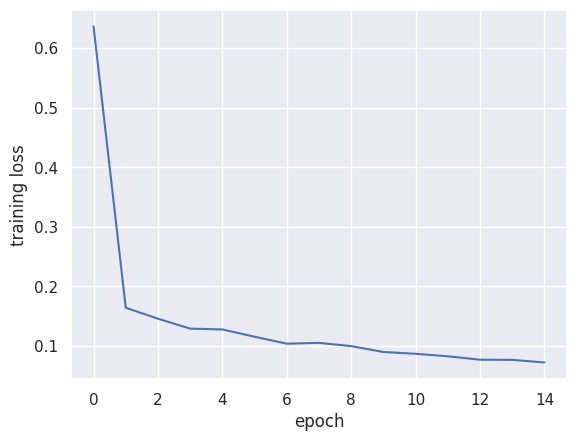

In [ ]:
plt.plot(train_loss)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

train dataset
###Extracting features###
Done
Sampling Per Class Dot Products


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


Sampling Intra Class Dot Products!


100%|██████████| 5000/5000 [00:00<00:00, 37455.43it/s]


Sampling Inter Class Dot Products!


100%|██████████| 5000/5000 [00:00<00:00, 20920.33it/s]


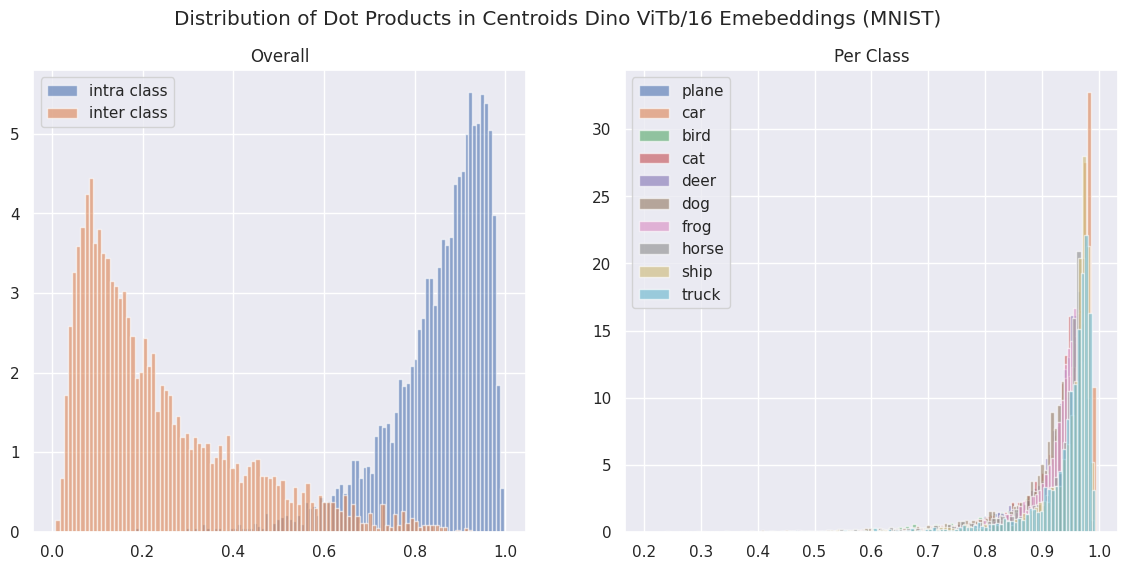

In [ ]:

# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(centroid_classifier, 'deep_centroids')

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device, verbose = False)


X = X_train
y = y_train


classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
           6: 'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

iterations_full = 5000
iterations_per_class = 10000

model_name = 'Centroids Dino ViTb/16'
dataset_name = 'MNIST'
suptitle = f'Distribution of Dot Products in {model_name} Emebeddings ({dataset_name})'
histogram_args = {'bins' : 100, 'density' : True, 'alpha' : 0.6}

plot_dot_products(X, y, iterations_full = iterations_full, iterations_per_class = iterations_per_class,
                  class_names = classes, histogram_args = histogram_args, suptitle = suptitle)
plt.show()

train dataset
###Extracting features###
Done
Sampling Per Class Dot Products


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


Sampling Intra Class Dot Products!


100%|██████████| 5000/5000 [00:00<00:00, 39093.08it/s]


Sampling Inter Class Dot Products!


100%|██████████| 5000/5000 [00:00<00:00, 22640.36it/s]


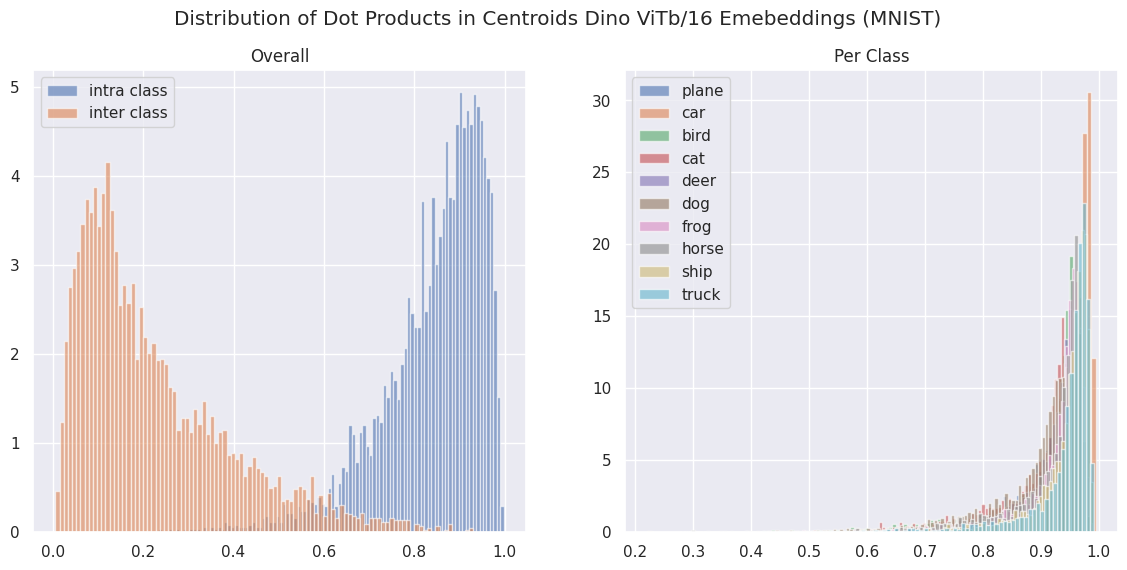

In [ ]:

# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(centroid_classifier, 'deep_centroids')

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device, verbose = False)


X = X_train
y = y_train


classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
           6: 'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

iterations_full = 5000
iterations_per_class = 10000

model_name = 'Centroids Dino ViTb/16'
dataset_name = 'MNIST'
suptitle = f'Distribution of Dot Products in {model_name} Emebeddings ({dataset_name})'
histogram_args = {'bins' : 100, 'density' : True, 'alpha' : 0.6}

plot_dot_products(X, y, iterations_full = iterations_full, iterations_per_class = iterations_per_class,
                  class_names = classes, histogram_args = histogram_args, suptitle = suptitle)
plt.show()

train dataset
###Extracting features###
Done
Sampling Per Class Dot Products


100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Sampling Intra Class Dot Products!


100%|██████████| 5000/5000 [00:00<00:00, 23031.71it/s]


Sampling Inter Class Dot Products!


100%|██████████| 5000/5000 [00:00<00:00, 14518.71it/s]


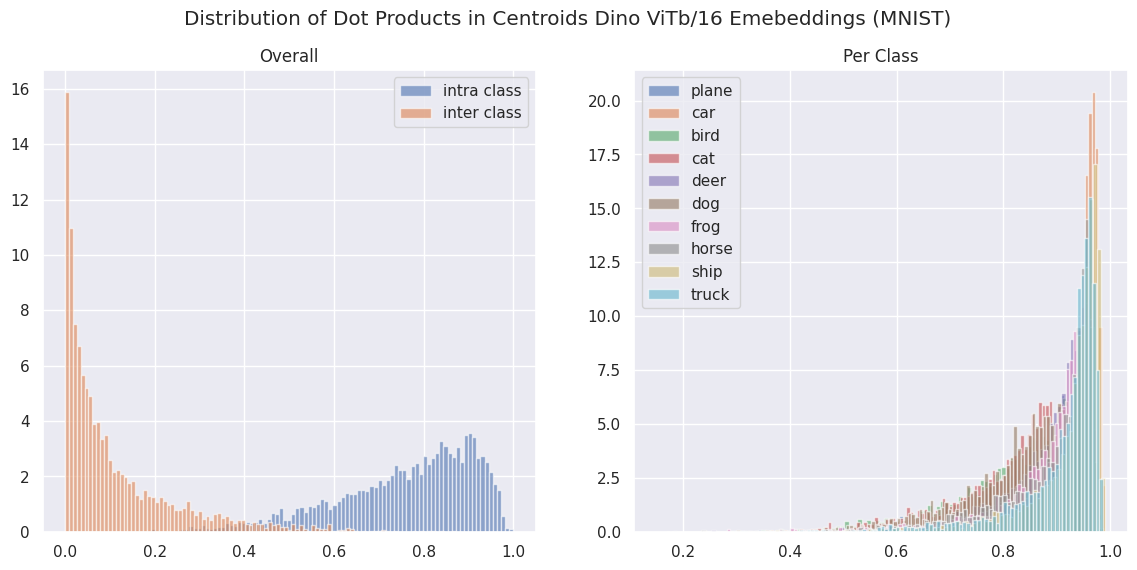

In [ ]:

# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(centroid_classifier, 'deep_centroids')

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device, verbose = False)


X = X_train
y = y_train


classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
           6: 'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

iterations_full = 5000
iterations_per_class = 10000

model_name = 'Centroids Dino ViTb/16'
dataset_name = 'MNIST'
suptitle = f'Distribution of Dot Products in {model_name} Emebeddings ({dataset_name})'
histogram_args = {'bins' : 100, 'density' : True, 'alpha' : 0.6}

plot_dot_products(X, y, iterations_full = iterations_full, iterations_per_class = iterations_per_class,
                  class_names = classes, histogram_args = histogram_args, suptitle = suptitle)
plt.show()

train dataset
###Extracting features###
Done
Sampling Per Class Dot Products


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


Sampling Intra Class Dot Products!


100%|██████████| 5000/5000 [00:00<00:00, 38028.88it/s]


Sampling Inter Class Dot Products!


100%|██████████| 5000/5000 [00:00<00:00, 22138.88it/s]


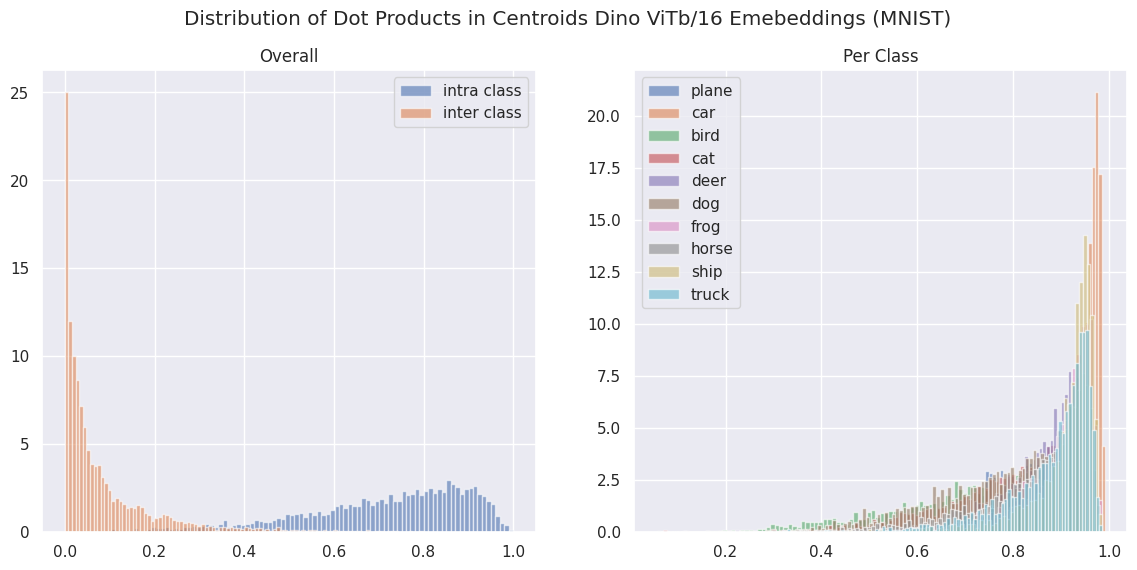

In [ ]:

# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(centroid_classifier, 'deep_centroids')

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device, verbose = False)


X = X_train
y = y_train


classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
           6: 'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

iterations_full = 5000
iterations_per_class = 10000

model_name = 'Centroids Dino ViTb/16'
dataset_name = 'MNIST'
suptitle = f'Distribution of Dot Products in {model_name} Emebeddings ({dataset_name})'
histogram_args = {'bins' : 100, 'density' : True, 'alpha' : 0.6}

plot_dot_products(X, y, iterations_full = iterations_full, iterations_per_class = iterations_per_class,
                  class_names = classes, histogram_args = histogram_args, suptitle = suptitle)
plt.show()

### MNIST

In [ ]:
root = '/content/drive/MyDrive'
dataset_name = 'mnist_torch'
model_name = 'dino_vitb16'

experiment_identifier = model_name + '_' + dataset_name
keys = ['X_train', 'y_train', 'X_test', 'y_test']
data = load_features(root, experiment_identifier, keys)

In [ ]:
# non private projection
dataloader_args = {'batch_size': 1000, 'shuffle': True}
optimizer_args = {'lr' : 4, 'momentum': 0.9}

train_dataloader, test_dataloader, centroid_classifier, optimizer, criterion = deep_centroids_experiment(data, dataloader_args, optimizer_args)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

centroid_classifier.to(device)
num_epochs = 50
train_loss = training_loop(centroid_classifier, train_dataloader,
                           test_dataloader, num_epochs, optimizer, criterion, device)

Training


100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


 Accuracy on the test images: 0.9787


train dataset
###Extracting features###
Done
Sampling Per Class Dot Products


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


Sampling Intra Class Dot Products!


100%|██████████| 5000/5000 [00:00<00:00, 39212.30it/s]


Sampling Inter Class Dot Products!


100%|██████████| 5000/5000 [00:00<00:00, 23782.60it/s]


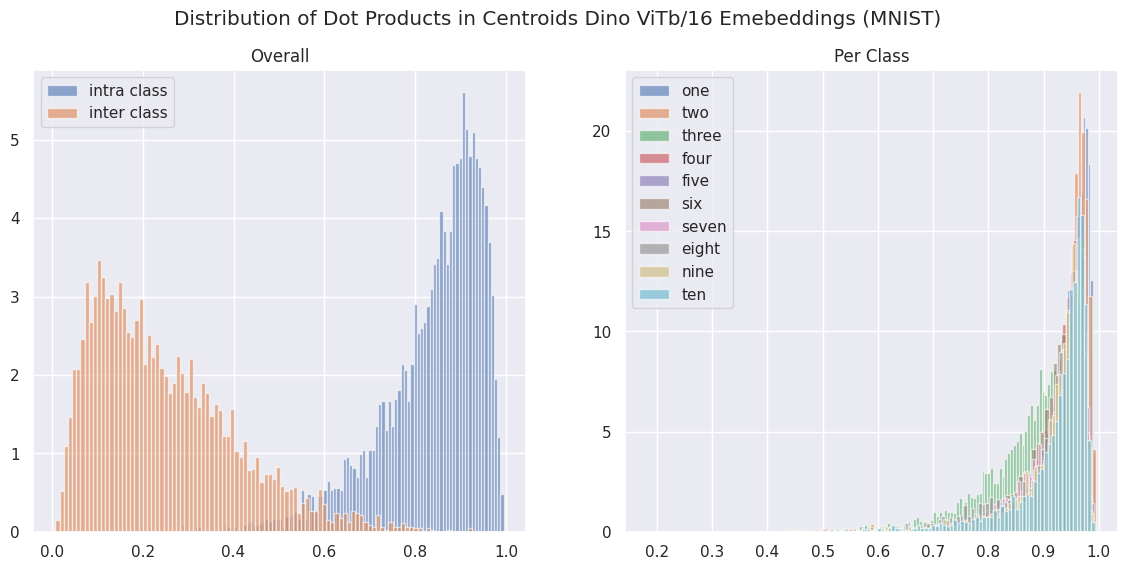

In [ ]:

# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(centroid_classifier, 'deep_centroids')

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device, verbose = False)


X = X_train
y = y_train



classes = {0: 'one', 1: 'two', 2: 'three', 3: 'four', 4: 'five', 5: 'six',
           6: 'seven', 7 : 'eight', 8 : 'nine', 9 : 'ten'}

iterations_full = 5000
iterations_per_class = 10000

model_name = 'Centroids Dino ViTb/16'
dataset_name = 'MNIST'
suptitle = f'Distribution of Dot Products in {model_name} Emebeddings ({dataset_name})'
histogram_args = {'bins' : 100, 'density' : True, 'alpha' : 0.6}

plot_dot_products(X, y, iterations_full = iterations_full, iterations_per_class = iterations_per_class,
                  class_names = classes, histogram_args = histogram_args, suptitle = suptitle)
plt.show()

### R152

In [ ]:
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'resnet152'
model_dict = ModelExperiment(model_name = model_name).get_model()
model = model_dict['model']
model.to(device)




# data
preprocessing_args = dict()
preprocessing_args['type'] = 'imagenet'

dataloader_args = dict()
dataloader_args['batch_size'] = 128

dataset_name = 'cifar10_torch'

dataset = DatasetExperiment(name = dataset_name, preprocessing_args = preprocessing_args)
train_dataloader, test_dataloader = dataset.get_dataloaders(dataloader_args)



# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(model, model_name)

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device, verbose = True)

# get test embeddings
print('test dataset')
X_test, y_test = feature_extractor.extract(test_dataloader, device, verbose = True)


## store features
data = {'X_train' : X_train, 'y_train' : y_train, 'X_test': X_test, 'y_test': y_test}
root = '/content/drive/MyDrive'
experiment_identifier = model_name + '_' + dataset_name

store_features(data, root = root, experiment_identifier=experiment_identifier)

Files already downloaded and verified
Files already downloaded and verified
train dataset
###Extracting features###


100%|██████████| 391/391 [00:52<00:00,  7.41it/s]


Done
test dataset
###Extracting features###


100%|██████████| 79/79 [00:05<00:00, 14.12it/s]


Done


In [ ]:
# non private projection
dataloader_args = {'batch_size': 1000, 'shuffle': True}
optimizer_args = {'lr' : 1e-2}

train_dataloader, test_dataloader, centroid_classifier, optimizer, criterion = deep_centroids_experiment(data, dataloader_args, optimizer_args)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

centroid_classifier.to(device)
num_epochs = 10
train_loss = training_loop(centroid_classifier, train_dataloader,
                           test_dataloader, num_epochs, optimizer, criterion, device)

Training


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


 Accuracy on the test images: 0.6637


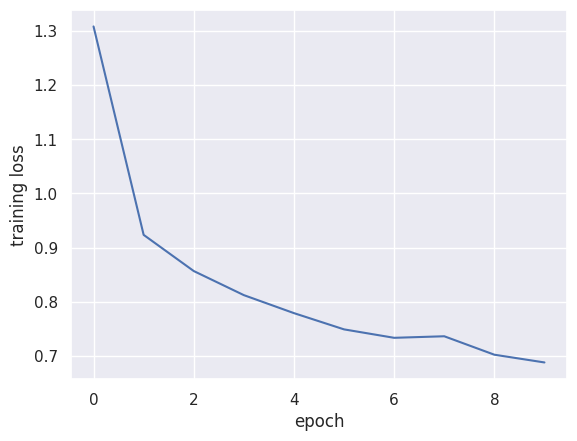

In [ ]:
plt.plot(train_loss)
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.show()

train dataset
###Extracting features###
Done
Sampling Per Class Dot Products


100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Sampling Intra Class Dot Products!


100%|██████████| 5000/5000 [00:00<00:00, 30520.50it/s]


Sampling Inter Class Dot Products!


100%|██████████| 5000/5000 [00:00<00:00, 19102.63it/s]


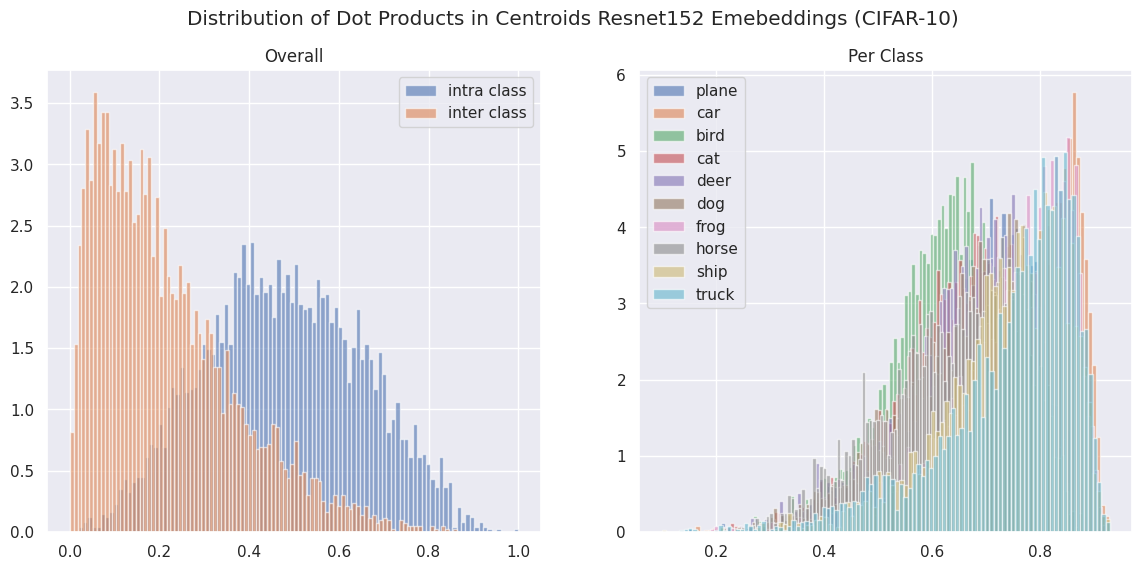

In [ ]:

# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(centroid_classifier, 'deep_centroids')

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device, verbose = False)


X = X_train
y = y_train


classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
           6: 'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

iterations_full = 5000
iterations_per_class = 10000

model_name = 'Centroids Resnet152'
dataset_name = 'CIFAR-10'
suptitle = f'Distribution of Dot Products in {model_name} Emebeddings ({dataset_name})'
histogram_args = {'bins' : 100, 'density' : True, 'alpha' : 0.6}

plot_dot_products(X, y, iterations_full = iterations_full, iterations_per_class = iterations_per_class,
                  class_names = classes, histogram_args = histogram_args, suptitle = suptitle)
plt.show()

## OOD

### Dino

In [ ]:
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'dino_vitb16'
model_dict = ModelExperiment(model_name = model_name).get_model()
model = model_dict['model']
model.to(device)




# data
preprocessing_args = dict()
preprocessing_args['type'] = 'imagenet_resize'
preprocessing_args['resize_size'] = 224

dataloader_args = dict()
dataloader_args['batch_size'] = 32

dataset_name = 'cifar10_torch'
dataset = DatasetExperiment(name = dataset_name, preprocessing_args = preprocessing_args)
train_dataloader, test_dataloader = dataset.get_dataloaders(dataloader_args)

dataset_name = 'svhn_torch'
_, test_dataloader_ood = dataset.get_dataloaders(dataloader_args)


# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(model, model_name)

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device, verbose = False)

# get test embeddings
print('test dataset')
X_test, y_test = feature_extractor.extract(test_dataloader, device, verbose = False)


# get ood test embeddings
print('ood test dataset')
ood_X_test, ood_y_test = feature_extractor.extract(test_dataloader_ood, device, verbose = False)


data = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}

In [ ]:
dataloader_args = {'batch_size': 1000, 'shuffle': True}
optimizer_args = {'lr' : 4, 'momentum': 0.9}

train_dataloader, test_dataloader, centroid_classifier, optimizer, criterion = deep_centroids_experiment(data, dataloader_args, optimizer_args)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

centroid_classifier.to(device)
num_epochs = 30
train_loss = training_loop(centroid_classifier, train_dataloader,
                           test_dataloader, num_epochs, optimizer, criterion, device)

In [ ]:
# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(centroid_classifier, 'deep_centroids')

dataloader_args = {'batch_size':1000, 'shuffle':True}
train_dataloader = get_dataloader_from_xy(X_train, y_train, dataloader_args)

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device, verbose = False)



data_id = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': np.zeros((X_test.shape[0],1))}
data_ood = {'X_test' : ood_X_test, 'y_test' : np.ones((ood_X_test.shape[0],1))}

ood_exp_X_test = np.vstack((X_test, ood_X_test))
ood_exp_y_test = np.vstack((data_id['y_test'], data_ood['y_test']))



# get test embeddings
test_dataloader = get_dataloader_from_xy(ood_exp_X_test, ood_exp_y_test, dataloader_args)
ood_exp_X_test, ood_exp_y_test = feature_extractor.extract(train_dataloader, device, verbose = False)

train dataset
###Extracting features###
Done
###Extracting features###
Done


In [ ]:
ood = CentroidOOD()
ood.fit_labeled(data_id['X_train'], data_id['y_train'])

ents = ood.predict_ood(ood_exp_X_test)
ents_dict = {'ID': ents[(ood_exp_y_test == 0).squeeze()], 'OOD' : ents[(ood_exp_y_test == 1).squeeze()]}

hist_args = {'bins' : 50, 'density' : True}
results = plot_hist_dict(ents_dict, title='OOD Scores', histogram_args = hist_args)

plt.xlabel('Entropy')

plt.show()

### vgg19

In [ ]:
# model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'vgg19'
model_dict = ModelExperiment(model_name = model_name).get_model()
model = model_dict['model']
model.to(device)

In [ ]:

# data
preprocessing_args = dict()
preprocessing_args['type'] = 'imagenet'

dataloader_args = dict()
dataloader_args['batch_size'] = 128

dataset_name = 'cifar10_torch'
dataset = DatasetExperiment(name = dataset_name, preprocessing_args = preprocessing_args)
train_dataloader, test_dataloader = dataset.get_dataloaders(dataloader_args)

dataset_name = 'svhn_torch'
_, test_dataloader_ood = dataset.get_dataloaders(dataloader_args)


# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(model, model_name)

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device, verbose = False)

# get test embeddings
print('test dataset')
X_test, y_test = feature_extractor.extract(test_dataloader, device, verbose = False)


# get ood test embeddings
print('ood test dataset')
ood_X_test, ood_y_test = feature_extractor.extract(test_dataloader_ood, device, verbose = False)


data = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}

Files already downloaded and verified
Files already downloaded and verified
train dataset
###Extracting features###
Done
test dataset
###Extracting features###
Done
ood test dataset
###Extracting features###
Done


In [ ]:
# non private projection
dataloader_args = {'batch_size': 1000, 'shuffle': True}
optimizer_args = {'lr' : 1e-4}

train_dataloader, test_dataloader, centroid_classifier, optimizer, criterion = deep_centroids_experiment(data, dataloader_args, optimizer_args,
                                                                                                         classifier_type = 'linear', optimizer_type = 'Adam')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

centroid_classifier.to(device)
num_epochs = 15
train_loss = training_loop(centroid_classifier, train_dataloader,
                           test_dataloader, num_epochs, optimizer, criterion, device)

Training


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


 Accuracy on the test images: 0.6104


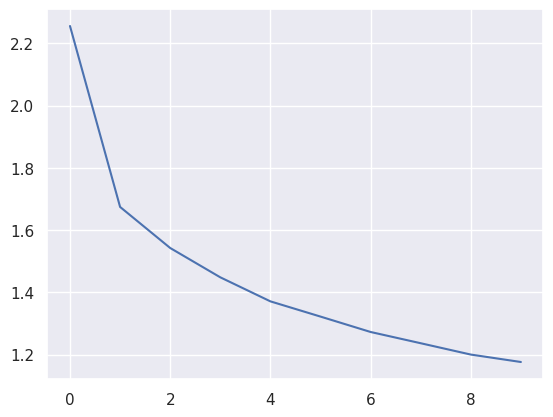

In [ ]:
plt.plot(train_loss)
plt.show()

In [ ]:
# feature extraction
feature_extractor = ImageFeatureExtractor_Torch(centroid_classifier, 'deep_centroids')

dataloader_args = {'batch_size':1000, 'shuffle':True}
train_dataloader = get_dataloader_from_xy(X_train, y_train, dataloader_args)

# get train embeddings
print('train dataset')
X_train, y_train = feature_extractor.extract(train_dataloader, device, verbose = False)



data_id = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': np.zeros((X_test.shape[0],1))}
data_ood = {'X_test' : ood_X_test, 'y_test' : np.ones((ood_X_test.shape[0],1))}

ood_exp_X_test = np.vstack((X_test, ood_X_test))
ood_exp_y_test = np.vstack((data_id['y_test'], data_ood['y_test']))



# get test embeddings
test_dataloader = get_dataloader_from_xy(ood_exp_X_test, ood_exp_y_test, dataloader_args)
ood_exp_X_test, ood_exp_y_test = feature_extractor.extract(train_dataloader, device, verbose = False)

train dataset
###Extracting features###
Done
###Extracting features###
Done


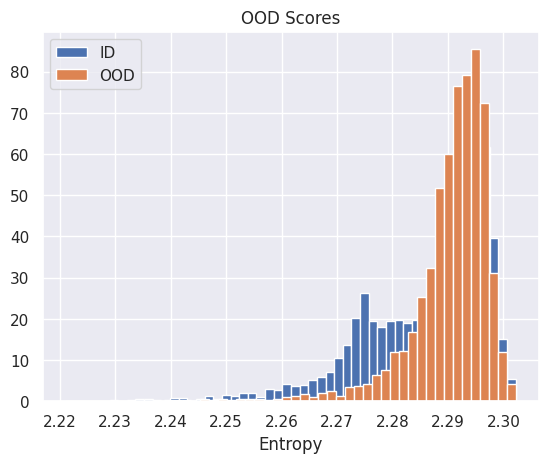

In [ ]:
ood = CentroidOOD()
ood.fit_labeled(data_id['X_train'], data_id['y_train'])

ents = ood.predict_ood(ood_exp_X_test)
ents_dict = {'ID': ents[(ood_exp_y_test == 0).squeeze()], 'OOD' : ents[(ood_exp_y_test == 1).squeeze()]}

hist_args = {'bins' : 50, 'density' : True}
results = plot_hist_dict(ents_dict, title='OOD Scores', histogram_args = hist_args)

plt.xlabel('Entropy')

plt.show()